# 1. Load all needed packages and files

need to set up everthing first, making sure all packages are installed, making sure we're able to import needed methods from the scan (Unsupervised_classification repository) and all needed files (like embeddings and clusters) are ready.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import torchvision
from torch.utils.data import DataLoader, Subset
from sklearn.neighbors import NearestNeighbors
import yaml
import sys
import os
import random

# Set random seeds for reproducibility
np.random.seed(53)


# Create Path to relevant directories
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Unsupervised-Classification')) # path to scan project
results_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'results')) # path to results
dataset_path = os.path.join(results_path, 'cifar-10', 'datasets') # path to cifar-10 dataset

# Add the project path to sys.path so Python can find the modules
sys.path.append(project_path)
sys.path.append(results_path)
sys.path.append(dataset_path)

# check gpu availability
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# Print the device being used
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Import the repository's functions
from utils.config import create_config
from utils.common_config import get_train_dataset, get_val_transformations



# Create Path to relevant directories
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Unsupervised-Classification')) # path to scan project
results_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'results')) # path to results
dataset_path = os.path.join(results_path, 'cifar-10', 'datasets') # path to cifar-10 dataset

# The feature embeddings associated to scan with different cluster numbers (different clusters have different embeddings)
features_clusters10 = np.load(os.path.join(results_path, "cifar-10/scan/features_clusters10.npy"), allow_pickle=True)
features_clusters20 = np.load(os.path.join(results_path, "cifar-10/scan/features_clusters20.npy"), allow_pickle=True)
features_clusters30 = np.load(os.path.join(results_path, "cifar-10/scan/features_clusters30.npy"), allow_pickle=True)
features_clusters40 = np.load(os.path.join(results_path, "cifar-10/scan/features_clusters40.npy"), allow_pickle=True)
features_clusters50 = np.load(os.path.join(results_path, "cifar-10/scan/features_clusters50.npy"), allow_pickle=True)
features_clusters60 = np.load(os.path.join(results_path, "cifar-10/scan/features_clusters60.npy"), allow_pickle=True)
#features_images = np.load(os.path.join(results_path, "features_seed1.npy"), allow_pickle=True)
#print(features_images)
print(features_clusters10.shape)
print(features_clusters20.shape)
print(features_clusters30.shape)
print(features_clusters40.shape)
print(features_clusters50.shape)
print(features_clusters60.shape)

# The probabilities of cluster arrangment associated to scan with different cluster numbers
probs_clusters10 = np.load(os.path.join(results_path, "cifar-10/scan/probs_clusters10.npy"), allow_pickle=True)
probs_clusters20 = np.load(os.path.join(results_path, "cifar-10/scan/probs_clusters20.npy"), allow_pickle=True)
probs_clusters30 = np.load(os.path.join(results_path, "cifar-10/scan/probs_clusters30.npy"), allow_pickle=True)
probs_clusters40 = np.load(os.path.join(results_path, "cifar-10/scan/probs_clusters40.npy"), allow_pickle=True)
probs_clusters50 = np.load(os.path.join(results_path, "cifar-10/scan/probs_clusters50.npy"), allow_pickle=True)
probs_clusters60 = np.load(os.path.join(results_path, "cifar-10/scan/probs_clusters60.npy"), allow_pickle=True)



(50000, 512)
(50000, 512)
(50000, 512)
(50000, 512)
(50000, 512)
(50000, 512)


Plotting features_clusters10 and features_clusters20


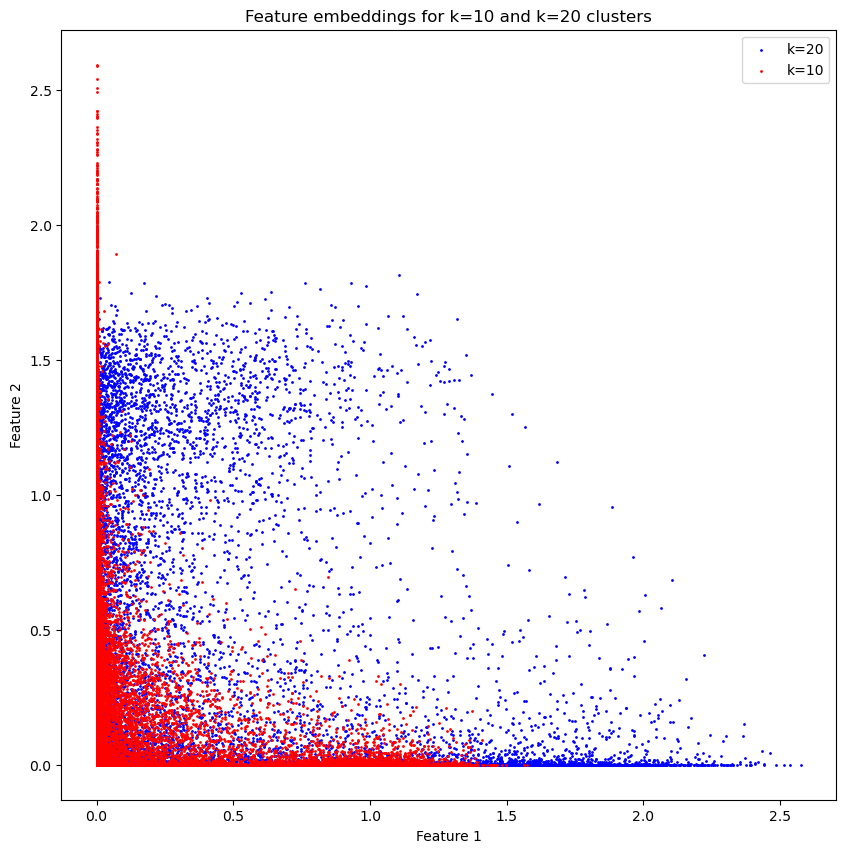

In [3]:

# Scan of different cluster numbers have different feature embeddings
print("Plotting features_clusters10 and features_clusters20")
plt.figure(figsize=(10, 10))
plt.scatter(features_clusters20[:, 0], features_clusters20[:, 1], s=1, c='blue', label='k=20')
plt.scatter(features_clusters10[:, 0], features_clusters10[:, 1], s=1, c='red', label='k=10')
plt.title('Feature embeddings for k=10 and k=20 clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()


the embeddings change when passing through the scan algorithm of different classes

## 2 load the dataset

we downloaded dataset from Scan Repo so must use those configurations

In [4]:
cifar10_path = os.path.join(dataset_path, 'cifar-10-batches-py')
print(f"Loading CIFAR-10 dataset from {cifar10_path}")

# Load the config to pass to the helper function

p = create_config(project_path+'/configs/env.yml', project_path+'/configs/pretext/simclr_cifar10.yml')

# Get the evaluation transformations
eval_transforms = get_val_transformations(p)

# Use the repository's function to load the dataset
# This will automatically use the path from mypath.py
print("Loading training dataset...")
# This will load the CIFAR-10 dataset with the specified transformations
train_dataset = get_train_dataset(p, transform=eval_transforms)

print("✅ Configuration loaded successfully.")
#print(f"Shape of embeddings: {train_embeddings10.shape}")
#print(f"Shape of cluster assignments: {train_probs10.shape}")

Loading CIFAR-10 dataset from /home/abdullah/ML_CW3/results/cifar-10/datasets/cifar-10-batches-py
Loading training dataset...
Files already downloaded and verified
Files already downloaded and verified
✅ Configuration loaded successfully.
✅ Configuration loaded successfully.


In [5]:
train_dataset.classes
train_dataset.class_to_idx

print(f"Number of classes in the dataset: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")
print(f"Class to Index Mapping: {train_dataset.class_to_idx}")




Number of classes in the dataset: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Class to Index Mapping: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


## 3. visualise some images

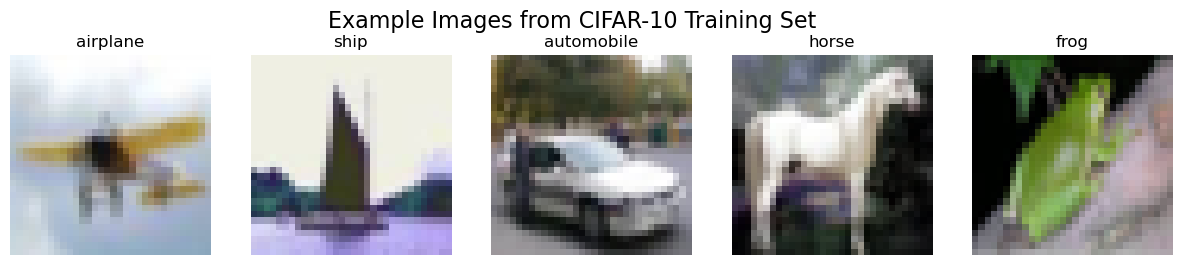

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Visualize Example Images

# the mean and std used for normalization (from the config files)
cifar10_mean = torch.tensor([0.4914, 0.4822, 0.4465])
cifar10_std = torch.tensor([0.2023, 0.1994, 0.2010])

# Number of images to display
num_images = 5

# Create a figure to display the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
fig.suptitle("Example Images from CIFAR-10 Training Set", fontsize=16)

for i in range(num_images):
    # 1. Get a random sample from the dataset
    random_index = random.randint(0, len(train_dataset) - 1)
    sample = train_dataset[random_index]
    
    # 2. Extract the image tensor and class name
    img_tensor = sample['image']
    class_name = sample['meta']['class_name']
    
    # 3. De-normalize the image tensor for visualization
    # We need to reshape mean and std to broadcast correctly
    img_display = img_tensor.clone()
    img_display = img_display * cifar10_std[:, None, None] + cifar10_mean[:, None, None]
    
    # 4. Convert from (C, H, W) to (H, W, C) for matplotlib and clip values (tensor to numpy)
    img_display_np = np.clip(img_display.permute(1, 2, 0).numpy(), 0, 1)
    
    # 5. Display the image
    ax = axes[i]
    ax.imshow(img_display_np)
    ax.set_title(class_name)
    ax.axis('off')

plt.show()


## 4. Visulaising clusters

Making sure the data has been clustered properly. you can commen this section out or use a subset (however a subset may not show all classes)

### 4.1 visulise cluster using t-sne for k = 10

Running t-SNE for dimensionality reduction


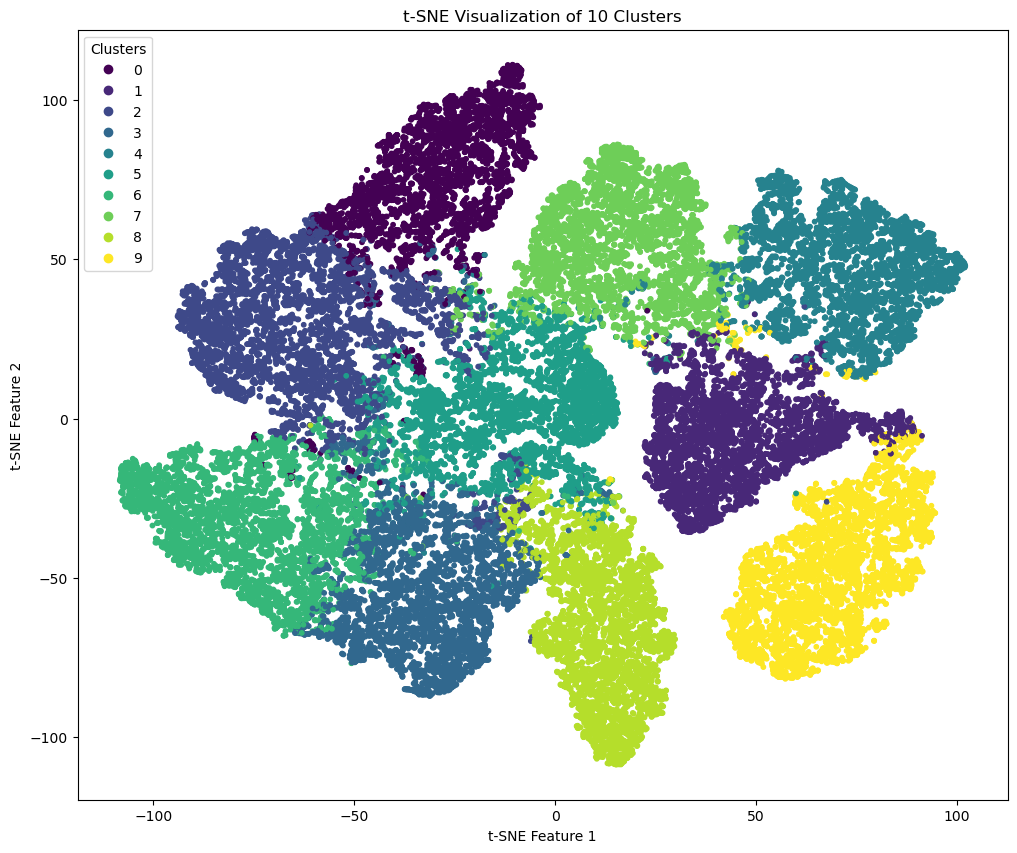

In [7]:
from sklearn.manifold import TSNE

k = 10

train_embeddings10 = features_clusters10 # Use the features from the 10 clusters
train_probs10 = probs_clusters10         # Use the probabilities from the 10 clusters


# convert probabilities into cluster arrangements
cluster_assignments_10 = np.argmax(train_probs10, axis=1)

# if you want to use subset, change to the following line
# train_embeddings10 - Use the first 5000 embeddings for faster plotting
# train_probs10 - Use the first 5000 probabilities for faster plotting

print("Running t-SNE for dimensionality reduction")
# We'll use a subset for a faster plot, for a full plot use all train_embeddings10
subset_indices = np.random.choice(len(train_embeddings10), 5000, replace=False)
embeddings_subset = train_embeddings10[subset_indices]
clusters_subset = cluster_assignments_10[subset_indices] # Use the array after argmax


# --- Visualize Clusters using t-SNE ---

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(train_embeddings10)

# --- Create the Scatter Plot ---
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_assignments_10, cmap='viridis', s=10)
plt.title(f't-SNE Visualization of {k} Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(k), title="Clusters")
plt.show()

### lets do k = 20

Running t-SNE for dimensionality reduction on the full dataset


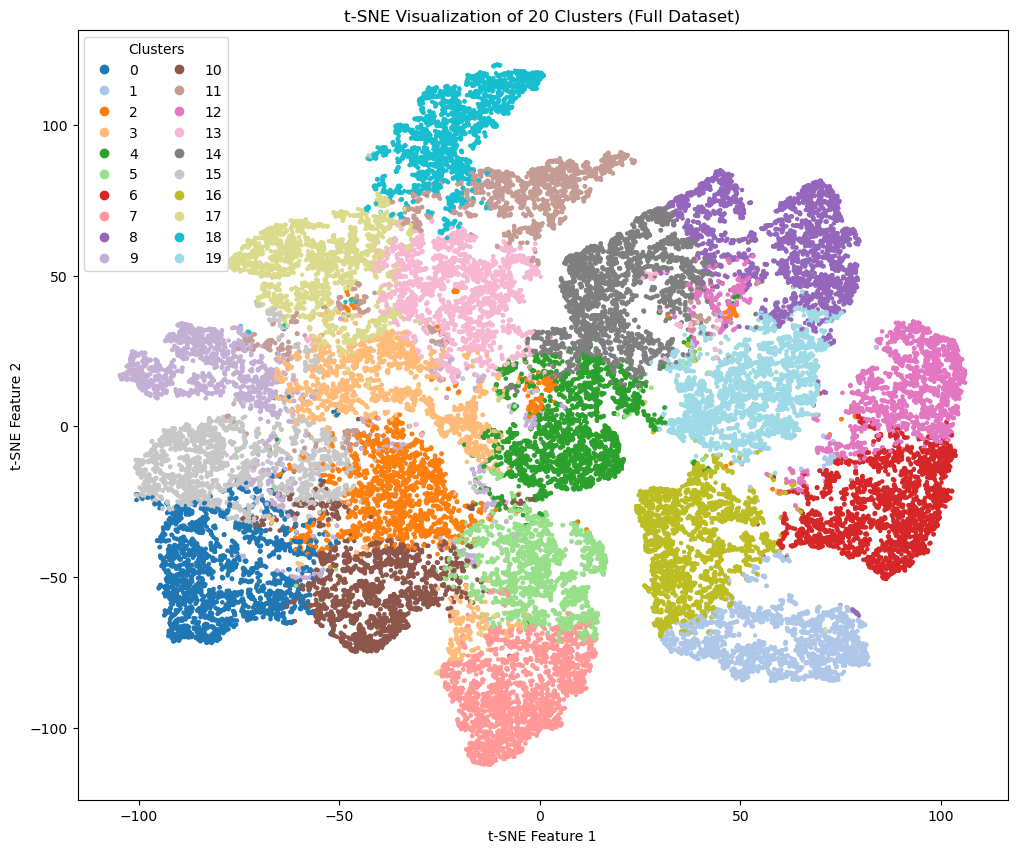

In [8]:
from sklearn.manifold import TSNE

# Load Data for k=20 (from your previous cell)
k = 20
features_20 = features_clusters20
cluster_assignments_20 = np.argmax(probs_clusters20, axis=1)

# --- Visualize Clusters using t-SNE on the FULL dataset ---
print("Running t-SNE for dimensionality reduction on the full dataset")

tsne_20_full = TSNE(n_components=2, perplexity=30, random_state=42)

# This is the line that will take a long time to execute
embeddings_2d_20_full = tsne_20_full.fit_transform(features_20)

# --- Create the Scatter Plot ---
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d_20_full[:, 0], embeddings_2d_20_full[:, 1], c=cluster_assignments_20, cmap='tab20', s=5)
plt.title(f't-SNE Visualization of {k} Clusters (Full Dataset)')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(handles=scatter.legend_elements(num=k)[0], labels=range(k), title="Clusters", ncol=2)
plt.show()

### do for k = 60

Running t-SNE for dimensionality reduction on the full dataset


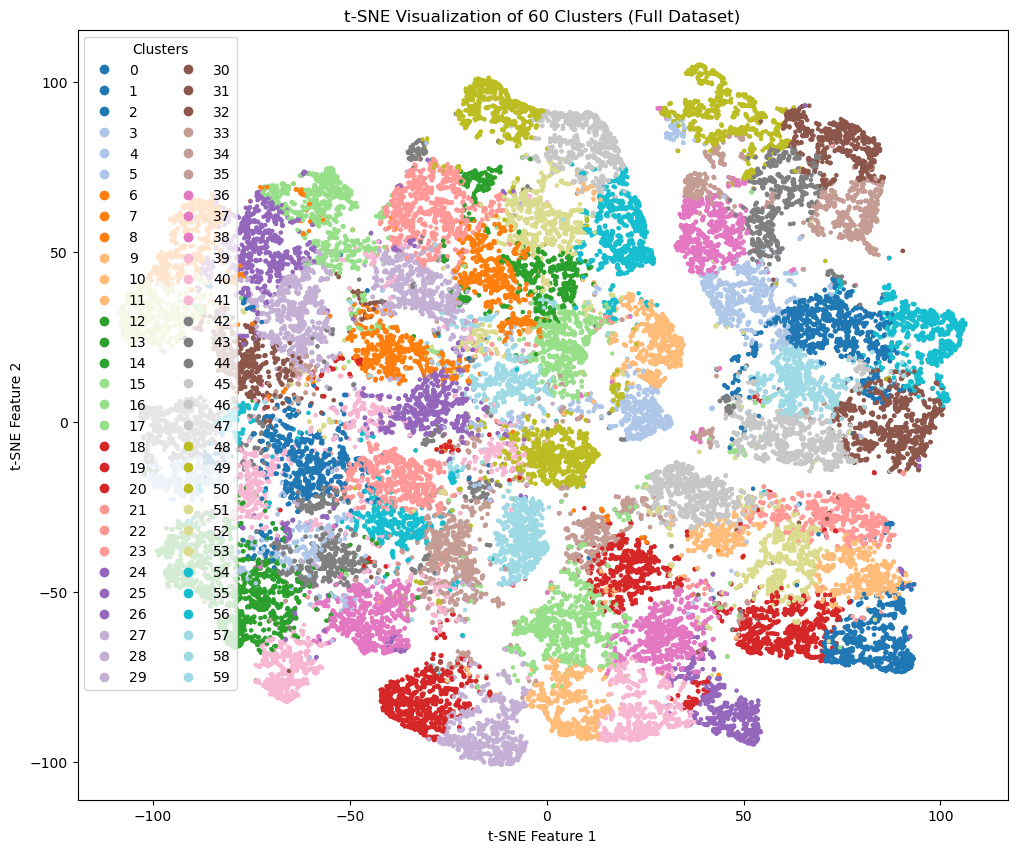

In [9]:
from sklearn.manifold import TSNE

# Load Data for k=60 (from your previous cell)
k = 60
features_60 = features_clusters60
cluster_assignments_60 = np.argmax(probs_clusters60, axis=1)

# --- Visualize Clusters using t-SNE on the FULL dataset ---
print("Running t-SNE for dimensionality reduction on the full dataset")

tsne_60_full = TSNE(n_components=2, perplexity=30, random_state=42)

# This is the line that will take a long time to execute
embeddings_2d_60_full = tsne_60_full.fit_transform(features_60)

# --- Create the Scatter Plot ---
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d_60_full[:, 0], embeddings_2d_60_full[:, 1], c=cluster_assignments_60, cmap='tab20', s=5)
plt.title(f't-SNE Visualization of {k} Clusters (Full Dataset)')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(handles=scatter.legend_elements(num=k)[0], labels=range(k), title="Clusters", ncol=2)
plt.show()

Looks like the datapoints have been clustered by the scan algorithm for k = [10,20,30,40,50,60]

## 5. Get most representative points using Typicality

$$ \text{Typicality}(x) = \left( \frac{1}{K} \sum_{x_i \in K\text{-NN}(x)} ||x - x_i||_2 \right)^{-1} $$

We use this formula to find the most representative and diverse datapoints within a cluster and store the image in a list to be trained on a resnet-18 model.
<br> Defines typicality as the once in the densest local neighbourhood based on euclidean distance to its k nearest neighbours

Phase 2: Iterative Active Learning Loop:
 
we now loop through the desired budget sizes. The following steps will be performed for each budget B in cumulative budget list (10, 20, 30, 40, 50, 60).

Track 1: TPC-DC (Cumulative Active Learning):
    
    1. Initialization: Start with an empty list of labeled_indices. The batch size for each iteration is B=10.
    
    2. Iteration 1 (Cumulative Budget = 10):
        ◦ Number of clusters = 0 + 10 = 10.
        ◦ Run SCAN to create 10 clusters.
        ◦ Select the 10 most typical points. Add their indices to labelled_indices.
    
    3. Iteration 2 (Cumulative Budget = 20):
        ◦ Number of clusters = 10 + 10 = 20.
        ◦ Run SCAN again to create 20 new clusters.
        ◦ Identify the clusters that do not contain any of the previous 10 labeled_indices.
        ◦ From these "uncovered" clusters, select 10 new typical points and add their indices to labeled_indices.
    
    4. Repeat: Continue this process for cumulative budgets of 30, 40, 50 and 60.

after we train a resnet-18 on each budgets labelled pool of images and evaluate models accuracy


###                             5.1 Defining Typicality formula


In [10]:
def compute_typicality(embeddings, k_neighbors=20):
    """Computes the typicality score for each embedding in a given array."""
    
    # Use scikit-learn for efficient nearest neighbor search
    nn = NearestNeighbors(n_neighbors=k_neighbors + 1) # +1 to include the point itself
    nn.fit(embeddings)
    distances, _ = nn.kneighbors(embeddings)
    
    # Calculate mean distance to the k nearest neighbors (excluding the point itself)
    mean_dist = distances[:, 1:].mean(axis=1)
    
    # Typicality is the inverse of the mean distance
    typicality_scores = 1.0 / (mean_dist + 1e-8) # Add epsilon for stability (incase mean_dist is zero)
    
    return typicality_scores

print("✅ Typicality function defined.")

✅ Typicality function defined.


### 5.2 initialise using k = 10 

want to visualise the images first and see how well its chooses from the dataset


In [11]:
# The list where we'll store the final selected image indices
selected_indices_typicality = []
k_neighbors = 20 # K for typicality calculation
min_cluster_size = 20 # Minimum samples in a cluster to select from

print(f"Finding the most typical sample for each of the {k} clusters...")

# Loop through each cluster ID (from 0 to 9)
for cluster_id in range(k):
    # Find the original indices of all images in this cluster
    original_indices_in_cluster = np.where(cluster_assignments_10 == cluster_id)[0]

    # Skip clusters that are too small (need min 20 data points in each cluster)
    if len(original_indices_in_cluster) < min_cluster_size:
        print(f"Skipping Cluster #{cluster_id}, size {len(original_indices_in_cluster)} < {min_cluster_size}")
        continue

    # Get the embeddings for just those images
    embeddings_in_cluster = train_embeddings10[original_indices_in_cluster]
    
    # Calculate typicality for all points within this cluster
    typicality_scores = compute_typicality(embeddings_in_cluster, k_neighbors=k_neighbors)
    
    # Find the local index of the most typical point (within the cluster)
    most_typical_local_idx = np.argmax(typicality_scores)
    
    # Get the original dataset index of this most typical point
    most_typical_original_idx = original_indices_in_cluster[most_typical_local_idx]
    
    # Add the selected index to our final list
    selected_indices_typicality.append(most_typical_original_idx)

# Print the selected indices for each cluster
print(f"Selected indices: {selected_indices_typicality}")

Finding the most typical sample for each of the 60 clusters...
Skipping Cluster #10, size 0 < 20
Skipping Cluster #11, size 0 < 20
Skipping Cluster #12, size 0 < 20
Skipping Cluster #13, size 0 < 20
Skipping Cluster #14, size 0 < 20
Skipping Cluster #15, size 0 < 20
Skipping Cluster #16, size 0 < 20
Skipping Cluster #17, size 0 < 20
Skipping Cluster #18, size 0 < 20
Skipping Cluster #19, size 0 < 20
Skipping Cluster #20, size 0 < 20
Skipping Cluster #21, size 0 < 20
Skipping Cluster #22, size 0 < 20
Skipping Cluster #23, size 0 < 20
Skipping Cluster #24, size 0 < 20
Skipping Cluster #25, size 0 < 20
Skipping Cluster #26, size 0 < 20
Skipping Cluster #27, size 0 < 20
Skipping Cluster #28, size 0 < 20
Skipping Cluster #29, size 0 < 20
Skipping Cluster #30, size 0 < 20
Skipping Cluster #31, size 0 < 20
Skipping Cluster #32, size 0 < 20
Skipping Cluster #33, size 0 < 20
Skipping Cluster #34, size 0 < 20
Skipping Cluster #35, size 0 < 20
Skipping Cluster #36, size 0 < 20
Skipping Cluster #3

### 5.3 visualise the chosen images by the typicality formula

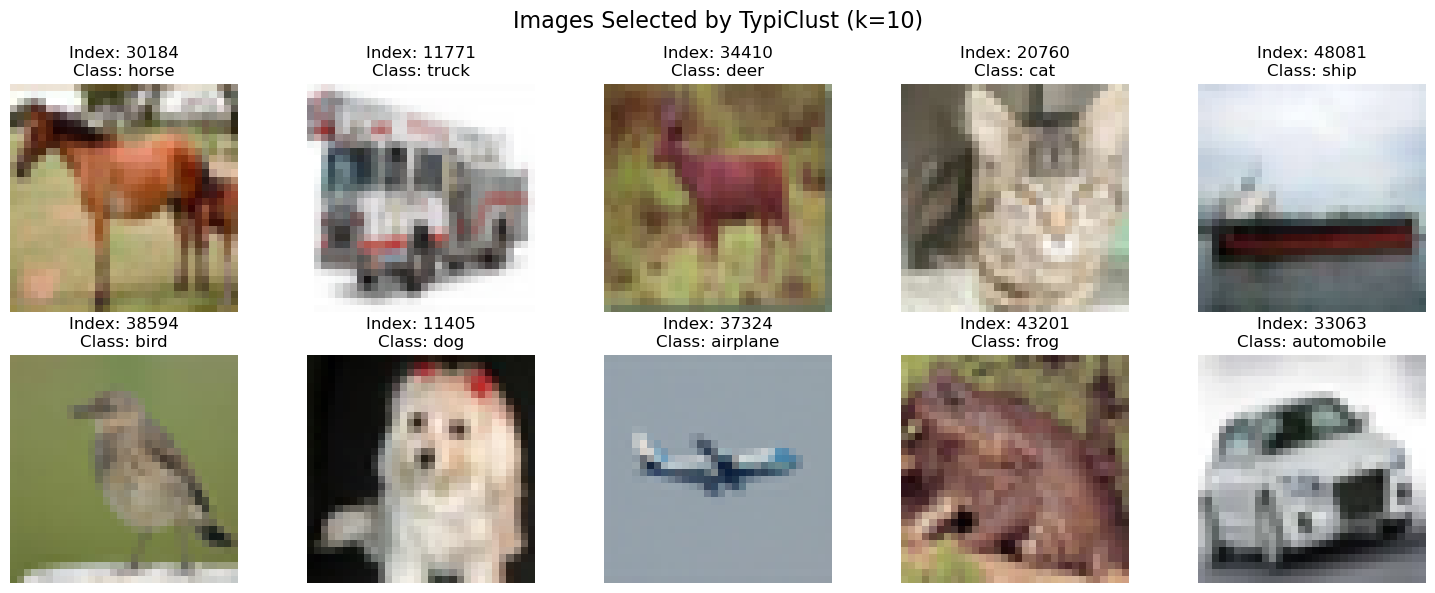

In [12]:
# Create a figure to display the 10 selected images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Images Selected by TypiClust (k=10)", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, img_index in enumerate(selected_indices_typicality):
    # Get the original image and label from the dataset
    sample = train_dataset[img_index]
    
    # The get_train_dataset function returns a dictionary
    class_name = sample['meta']['class_name']
    img_tensor = sample['image']
    
    # De-normalize the image for visualization
    img_display = img_tensor.clone()
    cifar10_mean = torch.tensor([0.4914, 0.4822, 0.4465])
    cifar10_std = torch.tensor([0.2023, 0.1994, 0.2010])
    img_display = img_display * cifar10_std[:, None, None] + cifar10_mean[:, None, None]
    img_display_np = np.clip(img_display.permute(1, 2, 0).numpy(), 0, 1)

    # Display the image
    axes[i].imshow(img_display_np)
    axes[i].set_title(f"Index: {img_index}\nClass: {class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

choose 10 distinct images (works pretty well)

In [13]:
############## Important Note ##################
# The following code is used to store the features and cluster assignments for different cluster numbers.

# Dictionary to hold all features
all_features = {
    10: features_clusters10,
    20: features_clusters20,
    30: features_clusters30,
    40: features_clusters40,
    50: features_clusters50,
    60: features_clusters60
}

# Dictionary to hold all cluster assignments (after argmax)
all_cluster_assignments = {
    10: np.argmax(probs_clusters10, axis=1),
    20: np.argmax(probs_clusters20, axis=1),
    30: np.argmax(probs_clusters30, axis=1),
    40: np.argmax(probs_clusters40, axis=1),
    50: np.argmax(probs_clusters50, axis=1),
    60: np.argmax(probs_clusters60, axis=1)
}

### 5.4 The Active learning Loop using typiclust with B=10

In [ ]:
# Active Learning Loop using TypiClust
B = 10 # our budget
most_typical_points = []



# 2. Initialistion
labeled_indices = set(most_typical_points) 
budgets_to_run = [10,20, 30, 40, 50, 60]

# Dictionary to store the cumulative list of indices at each budget
typiclust_cumulative_results = {10: list(labeled_indices)}

#  3. Iterative Selection Loop 
for k in budgets_to_run:
    print(f"\n{'='*20} Running for Cumulative Budget k={k} {'='*20}")
    
    # a. Get the features and cluster assignments for the current budget
    current_features = all_features[k]
    current_assignments = all_cluster_assignments[k]
    
    # b. Identify which of the new 'k' clusters are "covered"
    covered_cluster_ids = set()
    for idx in labeled_indices:
        cluster_id = current_assignments[idx]
        covered_cluster_ids.add(cluster_id)
    print(f"Found {len(covered_cluster_ids)} covered clusters containing previously labeled points.")

    # c. Find the most typical point from each "uncovered" cluster
    candidate_points = [] # To store (typicality_score, original_index)
    
    for cluster_id in range(k):
        if cluster_id in covered_cluster_ids:
            continue # Skip covered clusters
        
        # Get data for this uncovered cluster
        original_indices_in_cluster = np.where(current_assignments == cluster_id)[0]
        if len(original_indices_in_cluster) < min_cluster_size:
            continue
        
        embeddings_in_cluster = current_features[original_indices_in_cluster]
        
        # Find the most typical point and its score
        typicality_scores = compute_typicality(embeddings_in_cluster, k_neighbors=k_neighbors)
        most_typical_local_idx = np.argmax(typicality_scores)
        highest_typicality_score = typicality_scores[most_typical_local_idx]
        most_typical_original_idx = original_indices_in_cluster[most_typical_local_idx]
        
        candidate_points.append((highest_typicality_score, most_typical_original_idx))
    
    print(f"Found {len(candidate_points)} candidate points from {k - len(covered_cluster_ids)} uncovered clusters.")
    
    # d. Select the top B candidates with the highest typicality scores
    # Sort candidates by typicality score in descending order
    candidate_points.sort(key=lambda x: x[0], reverse=True)
    
    # Select the top B (e.g., 10) indices
    newly_selected_indices = [index for score, index in candidate_points[:B]]
    
    # e. Update the labeled pool
    labeled_indices.update(newly_selected_indices)
    
    # f. Store the cumulative results
    typiclust_cumulative_results[k] = (list(labeled_indices))
    print(f"✅ Selected {len(newly_selected_indices)} new points. Total labeled points: {len(labeled_indices)}")

print("\n\n--- Final Selected Indices for Each Cumulative Budget ---")
for budget, indices in typiclust_cumulative_results.items():
    print(f"Budget {budget}: {len(indices)} indices -> {indices[:15]}...") # Print first 15


==================== Running for Cumulative Budget k=10 ====================
Found 0 covered clusters containing previously labeled points.
Found 10 candidate points from 10 uncovered clusters.
✅ Selected 10 new points. Total labeled points: 10

==================== Running for Cumulative Budget k=20 ====================
Found 10 covered clusters containing previously labeled points.
Found 10 candidate points from 10 uncovered clusters.
✅ Selected 10 new points. Total labeled points: 20

==================== Running for Cumulative Budget k=30 ====================
Found 20 covered clusters containing previously labeled points.
Found 10 candidate points from 10 uncovered clusters.
✅ Selected 10 new points. Total labeled points: 30

==================== Running for Cumulative Budget k=40 ====================
Found 25 covered clusters containing previously labeled points.
Found 15 candidate points from 15 uncovered clusters.
✅ Selected 10 new points. Total labeled points: 40

============

In [15]:
# --- The final selected indices for each budget ---

typiclust_cumulative_results[10]
#typiclust_cumulative_results[20]
#typiclust_cumulative_results[30]
#typiclust_cumulative_results[40]
#typiclust_cumulative_results[50]
#typiclust_cumulative_results[60]

[43201, 38594, 33063, 30184, 34410, 37324, 11405, 48081, 20760, 11771]

### 5.5 Visualise the proprotions of classes chosen


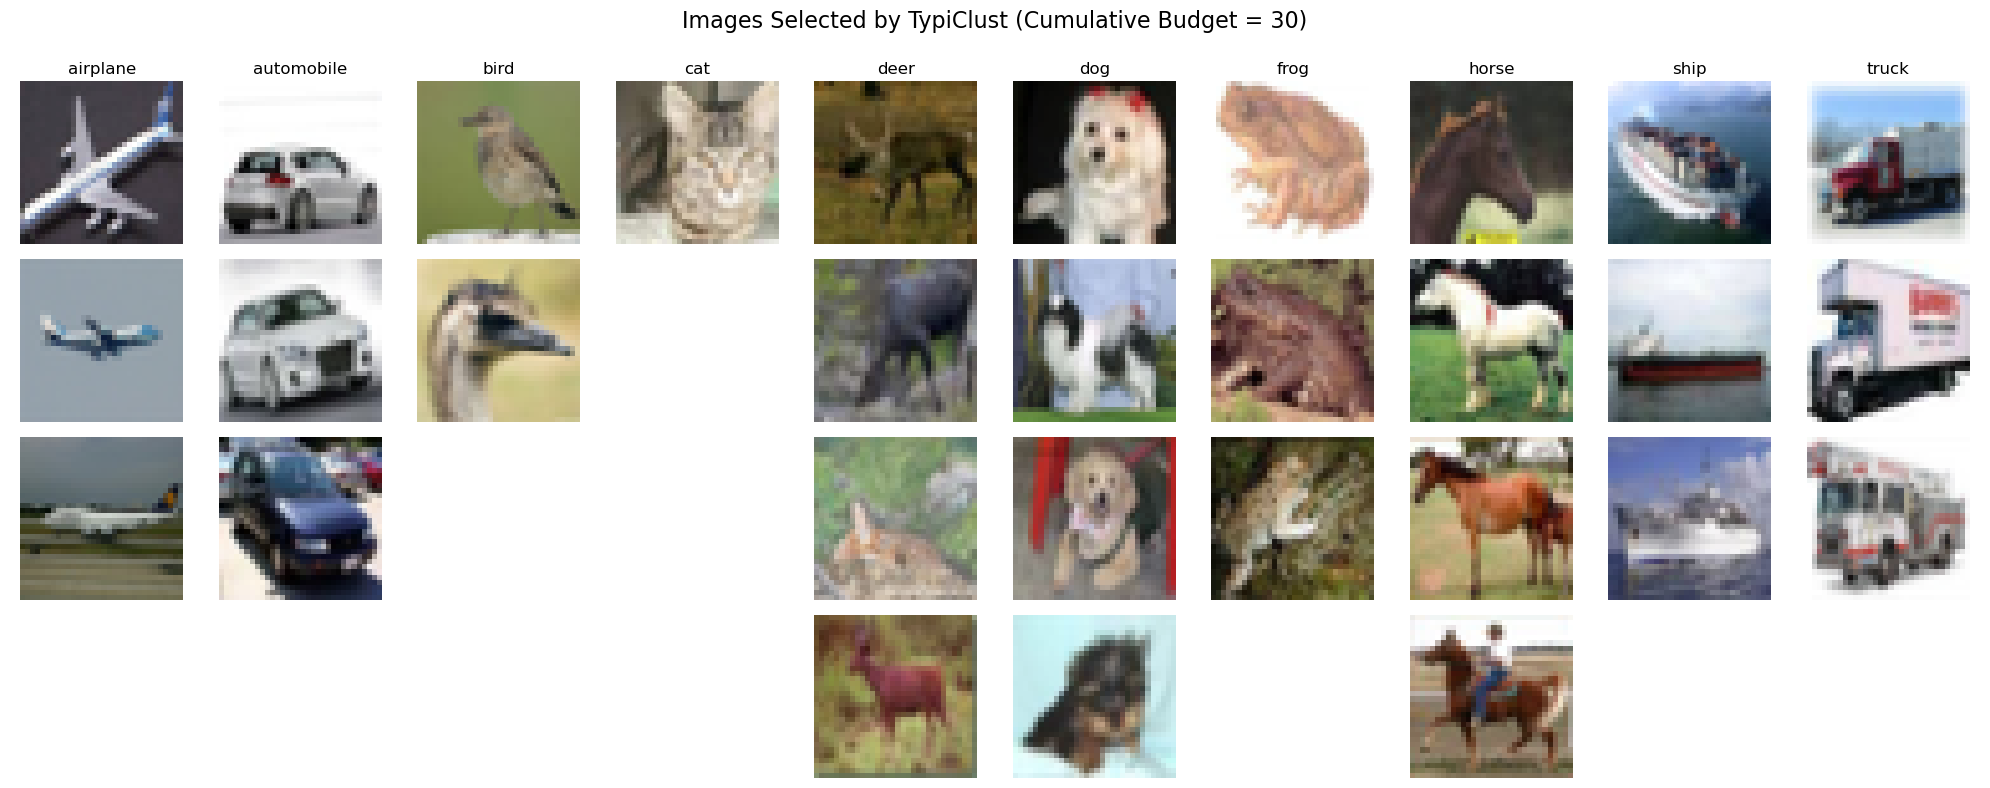

In [16]:
import collections

#  1. choose a budget to visualise
budget_to_visualize = 30 
selected_indices = typiclust_cumulative_results[budget_to_visualize]

# 2. Organize the images by class
# Create a dictionary where keys are class names and values are lists of images
images_by_class = collections.defaultdict(list)

# De-normalization stats (check scan config)
cifar10_mean = torch.tensor([0.4914, 0.4822, 0.4465])
cifar10_std = torch.tensor([0.2023, 0.1994, 0.2010])

for img_index in selected_indices:
    # Get the data from the dataset
    sample = train_dataset[img_index]
    class_name = sample['meta']['class_name']
    img_tensor = sample['image']
    
    # De-normalise the image for display
    img_display = img_tensor.clone()
    img_display = img_display * cifar10_std[:, None, None] + cifar10_mean[:, None, None]
    img_display_np = np.clip(img_display.permute(1, 2, 0).numpy(), 0, 1)
    
    # Add the display ready image to our dictionary
    images_by_class[class_name].append(img_display_np)

# --- 3. Create the Grid Plot 
# Determine the grid size
num_classes = len(train_dataset.classes)
max_images_per_class = max(len(imgs) for imgs in images_by_class.values()) if images_by_class else 1

fig, axes = plt.subplots(max_images_per_class, num_classes, figsize=(20, 2 * max_images_per_class))
fig.suptitle(f'Images Selected by TypiClust (Cumulative Budget = {budget_to_visualize})', fontsize=16)

# Get class names in order
class_names = train_dataset.classes

for col, class_name in enumerate(class_names):
    # Set the column title
    axes[0, col].set_title(class_name)
    
    # Get the images for this class
    class_images = images_by_class.get(class_name, [])
    
    for row in range(max_images_per_class):
        ax = axes[row, col]
        ax.axis('off') # Turn off axes for all cells
        
        # Display the image if it exists
        if row < len(class_images):
            ax.imshow(class_images[row])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

As you can see, it really struggles to decipher between cats. 

<br> It most likely struggles deciphering cats, dogs, deers and horses (4 legged, furry animals). they probably have very similar vector embeddings

<br> other than that, it chooses a good collection of images from each class

## 6. Defining cosine similarity as most representative point 

$$
\mathbf{p} = \underset{\mathbf{x} \in C}{\operatorname{arg\,max}} \frac{1} {\mathbf{d}} \sum_{\mathbf{c} \in C} \frac{\mathbf{x} \cdot \mathbf{c}}{\|\mathbf{x}\| \|\mathbf{c}\|}
$$

where:
- p = medoid (Most representative point)
- c is a point in cluster C (we do summation so every point in cluster)
- x is a datapoint in Cluster C
- d = total number of data points within Cluster

divide by d as a normalisation constant 

The goal is to find the data point with the highest similarity in a cluster and we define that as most representaive point. 

medoid defined as a point in a cluster that has the minimum average distance (or dissimilarity) to all other points within the cluster or a point that maximises similarity


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def select_medoids_iteratively(all_features, all_cluster_assignments, 
                               budgets_to_run, initial_labeled_indices, 
                               B=10, min_cluster_size=20):

    
    #1. Initialisation
    labeled_indices = set(initial_labeled_indices)
    cumulative_results_medoid = {10: sorted(list(labeled_indices))}

    # 2. Iterative Selection Loop 
    for k in budgets_to_run:
        print(f"\n{'='*20} Running Medoid Selection for k={k} {'='*20}")
        
        current_features = all_features[k]
        current_assignments = all_cluster_assignments[k]
        
        # a. Identify covered clusters
        covered_cluster_ids = {current_assignments[idx] for idx in labeled_indices}
        print(f"Found {len(covered_cluster_ids)} covered clusters.")

        # b. Find the medoid from each "uncovered" cluster
        candidate_points = []
        
        uncovered_cluster_ids = [cid for cid in range(k) if cid not in covered_cluster_ids]
        
        for cluster_id in uncovered_cluster_ids:
            original_indices_in_cluster = np.where(current_assignments == cluster_id)[0]
            
            if len(original_indices_in_cluster) < min_cluster_size:
                continue
            
            embeddings_in_cluster = current_features[original_indices_in_cluster]
            
            # calculate cosine similarity matrix
            similarity_matrix = cosine_similarity(embeddings_in_cluster)
            
            # Calculate average similarity for each point (sum of a points similarity divided by total points in cluster)
            avg_similarity = similarity_matrix.mean(axis=1)
            
            # Find the medoid (point with max average similarity)
            medoid_local_idx = np.argmax(avg_similarity)
            highest_avg_similarity = avg_similarity[medoid_local_idx]
            medoid_original_idx = original_indices_in_cluster[medoid_local_idx]
            
            candidate_points.append((highest_avg_similarity, medoid_original_idx))
            
        print(f"Found {len(candidate_points)} candidate medoids from uncovered clusters.")
        
        # c. Select the top B candidates with the highest average similarity
        candidate_points.sort(key=lambda x: x[0], reverse=True)
        newly_selected_indices = [index for score, index in candidate_points[:B]]
        
        # d. Update the labeled pool
        labeled_indices.update(newly_selected_indices)
        
        # e. Store the sorted cumulative results
        cumulative_results_medoid[k] = sorted(list(labeled_indices))
        print(f"✅ Selected {len(newly_selected_indices)} new points. Total labeled points: {len(labeled_indices)}")

    return cumulative_results_medoid



### 6.1 The actively learning loop except it uses medoid cosine similarity to find most representative point

In [18]:
# Assuming 'selected_indices_typicality' holds your initial 10 selections
initial_indices = [] 
budgets_to_run = [10, 20, 30, 40, 50, 60]

# Run the selection process for your modification
medoid_cumulative_results = select_medoids_iteratively(
    all_features, 
    all_cluster_assignments, 
    budgets_to_run,
    initial_indices
)

print("\n\n--- Final Medoid-Selected Indices for Each Cumulative Budget ---")
for budget, indices in medoid_cumulative_results.items():
    print(f"Budget {budget}: {len(indices)} indices -> {indices[:15]}...")


==================== Running Medoid Selection for k=10 ====================
Found 0 covered clusters.
Found 10 candidate medoids from uncovered clusters.
✅ Selected 10 new points. Total labeled points: 10

==================== Running Medoid Selection for k=20 ====================
Found 10 covered clusters.
Found 10 candidate medoids from uncovered clusters.
✅ Selected 10 new points. Total labeled points: 20

==================== Running Medoid Selection for k=30 ====================
Found 20 covered clusters.
Found 10 candidate medoids from uncovered clusters.
✅ Selected 10 new points. Total labeled points: 30

==================== Running Medoid Selection for k=40 ====================
Found 25 covered clusters.
Found 15 candidate medoids from uncovered clusters.
✅ Selected 10 new points. Total labeled points: 40

==================== Running Medoid Selection for k=50 ====================
Found 33 covered clusters.
Found 17 candidate medoids from uncovered clusters.
✅ Selected 10 new

In [19]:
medoid_cumulative_results[10]
#medoid_cumulative_results[20]
#medoid_cumulative_results[30]
#medoid_cumulative_results[40]
#medoid_cumulative_results[50]
#medoid_cumulative_results[60]

[1887, 5914, 8360, 12241, 12894, 20500, 32664, 33066, 37972, 38151]

### 6.2 Visualise class distribution for modification

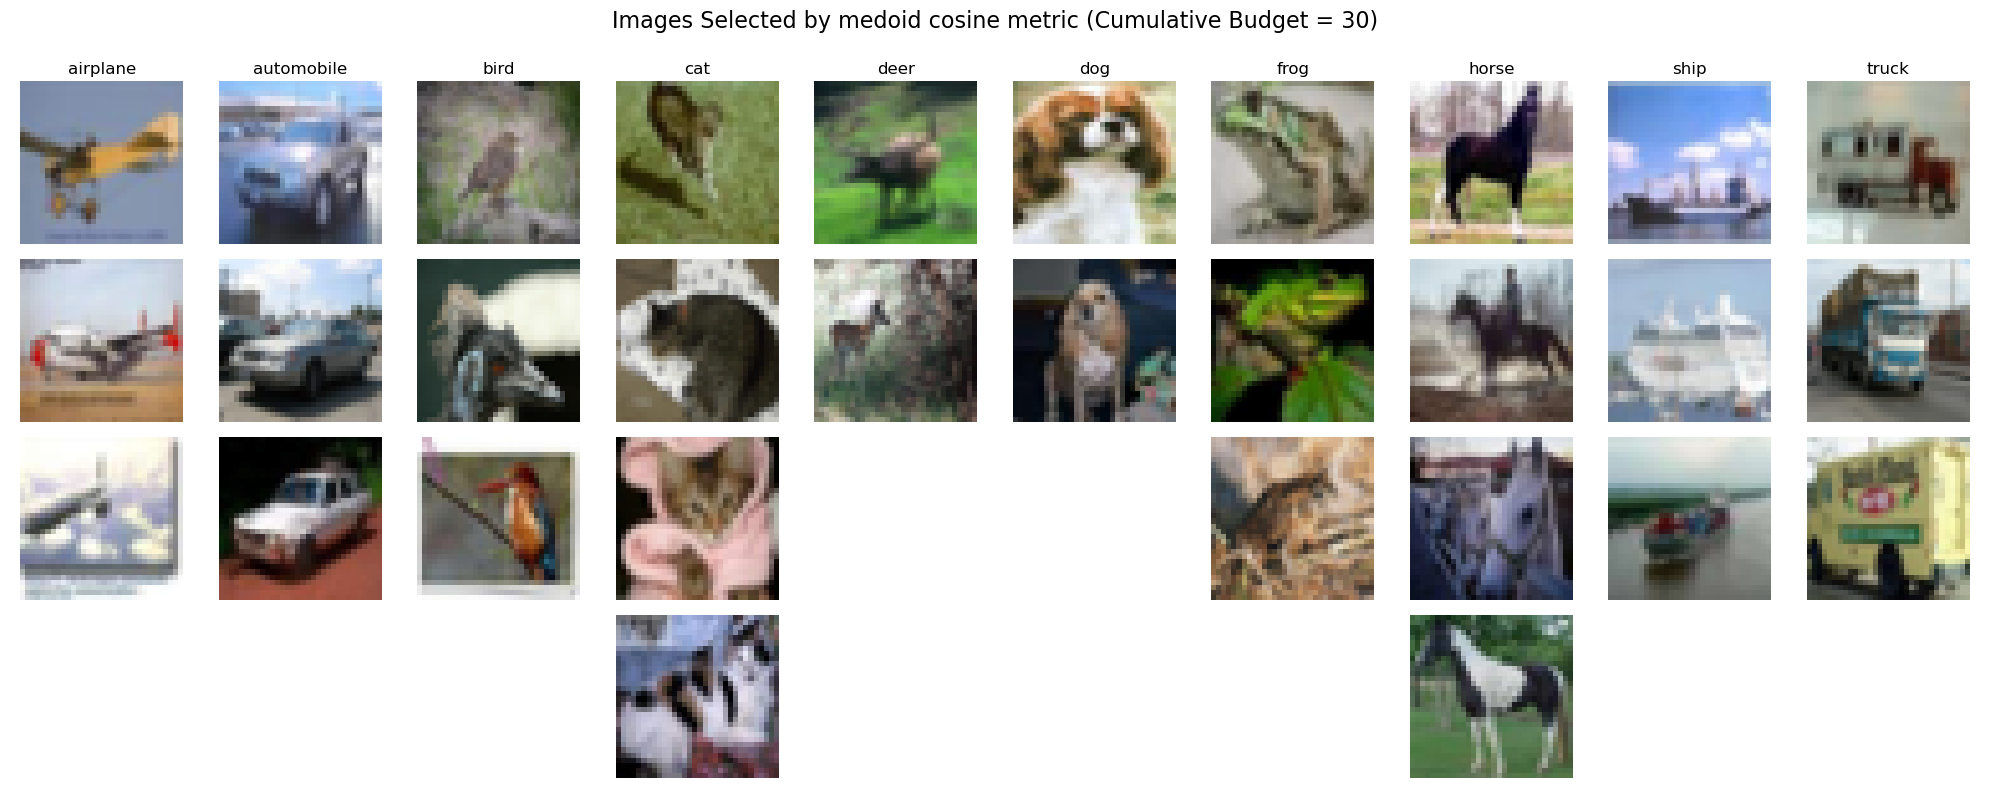

In [20]:
import collections

#  1. choose a budget to visualize
budget_to_visualise_medoid = 30 
selected_indices_medoid = medoid_cumulative_results[budget_to_visualise_medoid]

# 2. Organize the images by class
# Create a dictionary where keys are class names and values are lists of images
images_by_class = collections.defaultdict(list)

# De-normalization stats (check scan config)
cifar10_mean = torch.tensor([0.4914, 0.4822, 0.4465])
cifar10_std = torch.tensor([0.2023, 0.1994, 0.2010])

for img_index in selected_indices_medoid:
    # Get the data from the dataset
    sample = train_dataset[img_index]
    class_name = sample['meta']['class_name']
    img_tensor = sample['image']
    
    # De-normalise the image for display
    img_display = img_tensor.clone()
    img_display = img_display * cifar10_std[:, None, None] + cifar10_mean[:, None, None]
    img_display_np = np.clip(img_display.permute(1, 2, 0).numpy(), 0, 1)
    
    # Add the display ready image to our dictionary
    images_by_class[class_name].append(img_display_np)

# --- 3. Create the Grid Plot 
# Determine the grid size
num_classes = len(train_dataset.classes)
max_images_per_class = max(len(imgs) for imgs in images_by_class.values()) if images_by_class else 1

fig, axes = plt.subplots(max_images_per_class, num_classes, figsize=(20, 2 * max_images_per_class))
fig.suptitle(f'Images Selected by medoid cosine metric (Cumulative Budget = {budget_to_visualise_medoid})', fontsize=16)

# Get class names in order
class_names = train_dataset.classes

for col, class_name in enumerate(class_names):
    # Set the column title
    axes[0, col].set_title(class_name)
    
    # Get the images for this class
    class_images = images_by_class.get(class_name, [])
    
    for row in range(max_images_per_class):
        ax = axes[row, col]
        ax.axis('off')  # Turn off axes for all cells

        # Display the image if it exists
        if row < len(class_images):
            ax.imshow(class_images[row])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Our method of using cosine similarity to find has a decently distributed proportion of datapoints by the end. 

however, within the early iterations, it does fail to pick up certain classes

## 7. Find random baseline 

In [21]:
# 1. Initialisation
random_cumulative_results = {}
total_train_samples = len(train_dataset)
budgets_to_run_random = [10, 20, 30, 40, 50, 60]

print("Generating random baseline selections for each budget...")

# 2. Loop through each budget and sample randomly 
for k in budgets_to_run_random:
    # Select 'k' unique indices randomly from the entire training set
    random_indices = np.random.choice(total_train_samples, k, replace=False)
    
    # Store the sorted list of indices
    random_cumulative_results[k] = sorted(list(random_indices))

print(f"\n\n {'='*20}Final Randomly Selected Indices for Each Cumulative Budget {'='*20}")
for budget, indices in random_cumulative_results.items():
    print(f"Budget {budget}: {len(indices)} indices -> {indices[:15]}...")

Generating random baseline selections for each budget...


 ====================Final Randomly Selected Indices for Each Cumulative Budget ====================
Budget 10: 10 indices -> [2003, 10662, 13245, 16701, 17262, 29257, 31846, 32027, 36095, 43476]...
Budget 20: 20 indices -> [1754, 7477, 8615, 8810, 14101, 15318, 15913, 16334, 18268, 20020, 20435, 23987, 26271, 29787, 33281]...
Budget 30: 30 indices -> [1819, 3854, 5677, 8222, 8484, 8695, 10403, 13748, 14005, 14730, 16683, 17878, 20212, 20572, 22324]...
Budget 40: 40 indices -> [1695, 4008, 6325, 8800, 9665, 9992, 10271, 10686, 13411, 15788, 16705, 17471, 20128, 22074, 22506]...
Budget 50: 50 indices -> [140, 451, 569, 1078, 1260, 2177, 3977, 5138, 5754, 5793, 6522, 7587, 7699, 8179, 8240]...
Budget 60: 60 indices -> [3362, 3652, 4247, 6064, 6214, 6259, 7006, 8506, 11203, 11397, 12416, 12924, 13896, 15064, 15144]...


### 7.2 visualise the images chosen by random baseline

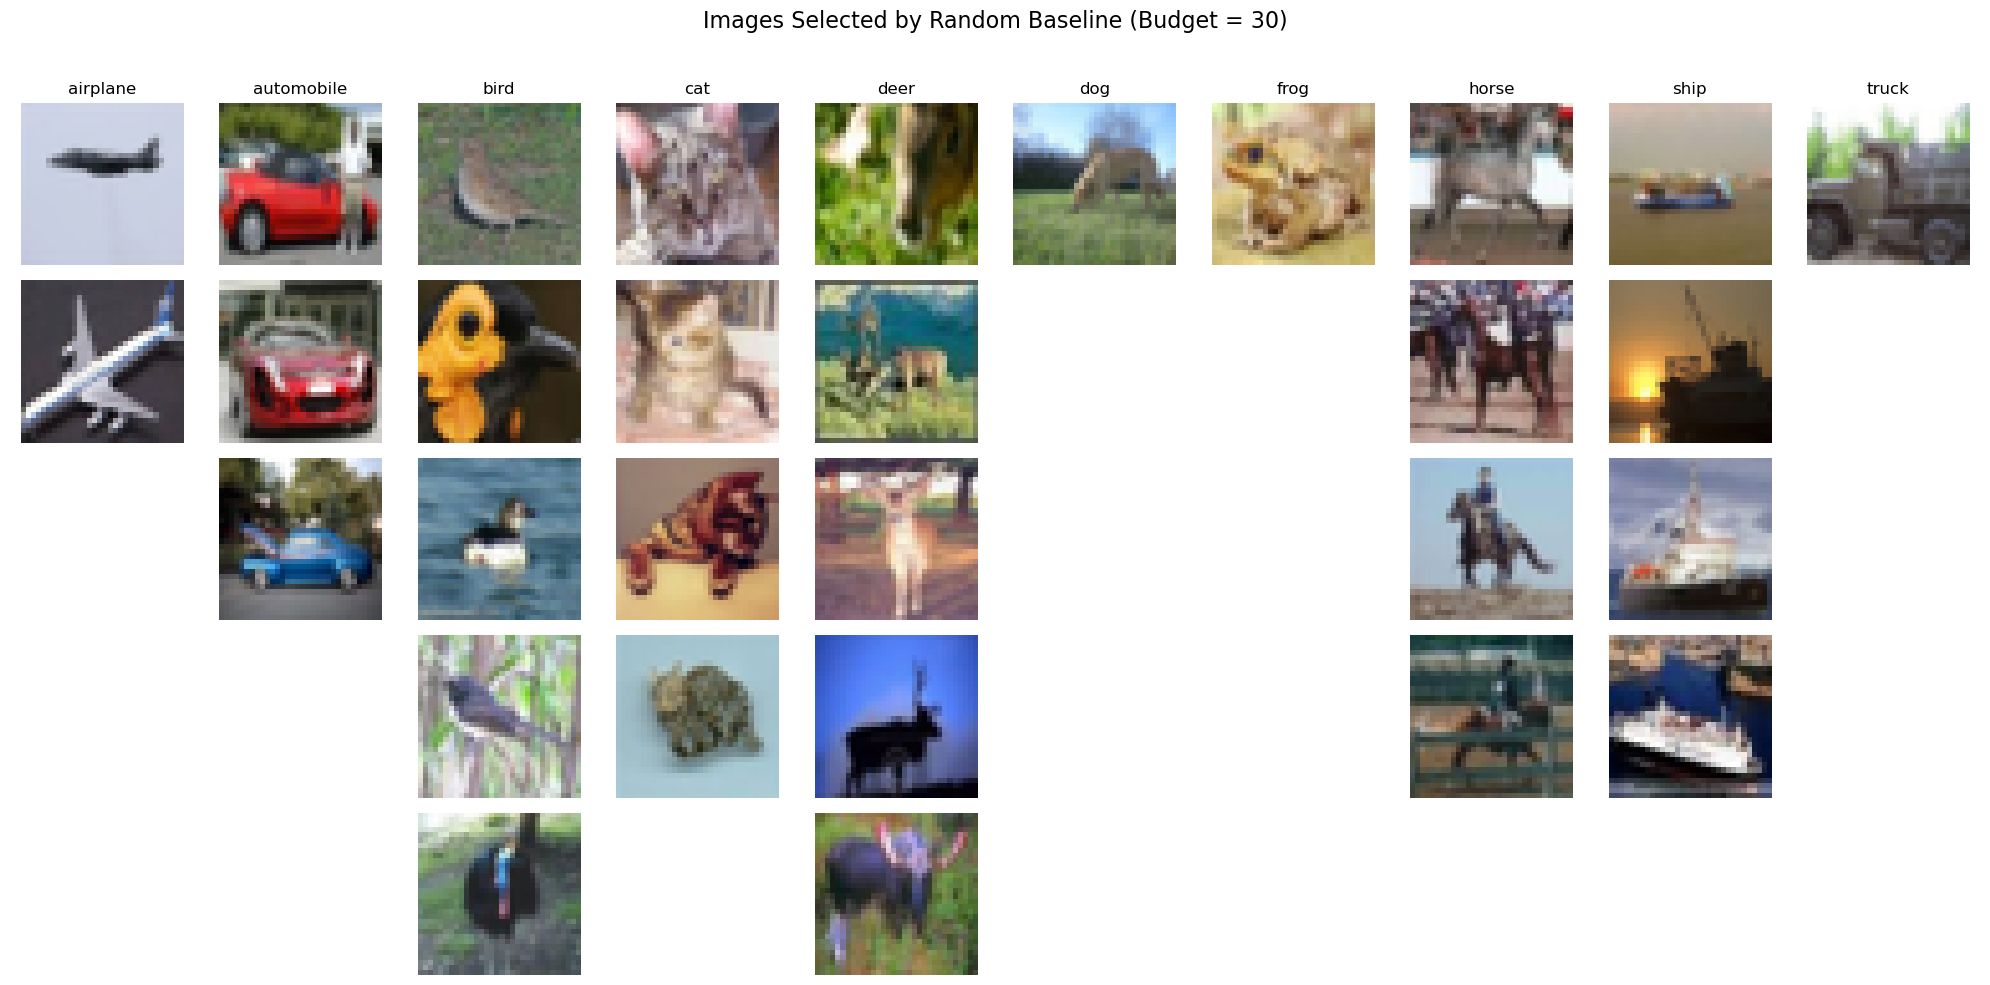

In [22]:
import collections

#  1. Get the 30 randomly selected indices
budget_to_visualize = 30
selected_indices_random = random_cumulative_results[budget_to_visualize]

#  2. Organize the images by class 
images_by_class_random = collections.defaultdict(list)

# De-normalization stats (assuming they are available from previous cells)
cifar10_mean = torch.tensor([0.4914, 0.4822, 0.4465])
cifar10_std = torch.tensor([0.2023, 0.1994, 0.2010])

for img_index in selected_indices_random:
    # Get the data from the dataset
    sample = train_dataset[img_index]
    class_name = sample['meta']['class_name']
    img_tensor = sample['image']
    
    # De-normalize the image for display
    img_display = img_tensor.clone()
    img_display = img_display * cifar10_std[:, None, None] + cifar10_mean[:, None, None]
    img_display_np = np.clip(img_display.permute(1, 2, 0).numpy(), 0, 1)
    
    # Add the display-ready image to our dictionary
    images_by_class_random[class_name].append(img_display_np)

# 3. Create the Grid Plot 
num_classes = len(train_dataset.classes)
max_images_per_class_random = max(len(imgs) for imgs in images_by_class_random.values()) if images_by_class_random else 1

fig, axes = plt.subplots(max_images_per_class_random, num_classes, figsize=(20, 2 * max_images_per_class_random))
fig.suptitle(f'Images Selected by Random Baseline (Budget = {budget_to_visualize})', fontsize=16)

class_names = train_dataset.classes

for col, class_name in enumerate(class_names):
    axes[0, col].set_title(class_name)
    class_images = images_by_class_random.get(class_name, [])
    
    for row in range(max_images_per_class_random):
        ax = axes[row, col]
        ax.axis('off')
        
        if row < len(class_images):
            ax.imshow(class_images[row])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 8. define and train the model on the three different strategies 
    1. Random baseline  
    2. Typiclust from the paper
    3. Modification of algorithm (medoid cosine similarity)

## 8.1 Define the resnet model

In [23]:
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18

#  Model Definition: ResNet18 for CIFAR-10 
# Create ResNet18 model without pretrained weights (training from scratch)
res_model = models.resnet18(weights=None)
# Replace the final fully-connected layer to output 10 classes for CIFAR-10
res_model.fc = nn.Linear(res_model.fc.in_features, 10)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_model.to(device)

#  Optimizer and Scheduler Setup 
optimiser = optim.SGD(res_model.parameters(), lr=0.025, momentum=0.9, nesterov=True)

# Use a cosine annealing learning rate scheduler over 100 epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=100)

print("ResNet18 model configured with SGD (lr=0.025, momentum=0.9, Nesterov=True) and CosineAnnealingLR scheduler.")


ResNet18 model configured with SGD (lr=0.025, momentum=0.9, Nesterov=True) and CosineAnnealingLR scheduler.


## 8.2 define some helper functions

In [24]:
# Helper Function to Create a New Model 
def create_resnet_model():
    """Creates a new ResNet-18 model with the specified configuration."""
    model = resnet18(weights=None) 
    model.fc = nn.Linear(model.fc.in_features, 10)
    model.to(device)
    return model

# --- Training Function ---
def train_model(model, train_indices, epochs=100):
    """Trains the model on a subset of the data defined by train_indices."""
    
    # Create a subset of the training data
    train_subset = Subset(train_dataset, train_indices)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    
    # Setup optimizer, scheduler, and loss function
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, nesterov=True)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    for epoch in range(epochs):
        for data in train_loader:
            inputs = data['image'].to(device)
            labels = data['target'].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        
    return model

# --- Evaluation Function ---
def evaluate_model(model, test_loader):
    """Evaluates the model's accuracy on the test set."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images = data['image'].to(device)
            labels = data['target'].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    return accuracy

print("✅ Training and evaluation functions defined.")

✅ Training and evaluation functions defined.


In [25]:
from torch.utils.data import DataLoader, Subset
# Create a DataLoader for the test set (do this once)
test_loader = DataLoader(get_train_dataset(p, transform=eval_transforms, split='test'), 
                         batch_size=256, shuffle=False)

Files already downloaded and verified


In [26]:
from tqdm import tqdm

# --- 1. Setup ---
budgets = [10, 20, 30, 40, 50, 60]
all_results = {
    "TypiClust": [],
    "Medoid (Cosine)": [],
    "Random Baseline": []
}

# Create a DataLoader for the test set (do this once)
test_loader = DataLoader(get_train_dataset(p, transform=eval_transforms, split='test'), 
                         batch_size=64, shuffle=False)

# --- 2. Main Loop ---
for k in tqdm(budgets, desc="Processing Budgets"):
    print(f"\n--- Evaluating for Budget k={k} ---")
    
    # Get the indices for each method for the current budget
    indices_sets = {
        "TypiClust": typiclust_cumulative_results[k],
        "Medoid (Cosine)": medoid_cumulative_results[k],
        "Random Baseline": random_cumulative_results[k]
    }
    
    for method, indices in indices_sets.items():
        print(f"Training model for: {method}...")
        
        # a. Create a fresh model for each run
        model = create_resnet_model()
        
        # b. Train the model on the selected indices
        trained_model = train_model(model, indices)
        
        # c. Evaluate the trained model
        accuracy = evaluate_model(trained_model, test_loader)
        print(f"Accuracy for {method} at k={k}: {accuracy:.2f}%")
        
        # d. Store the result
        all_results[method].append(accuracy)

print("\n\n✅ All evaluations complete.")

Files already downloaded and verified


Processing Budgets:   0%|          | 0/6 [00:00<?, ?it/s]


--- Evaluating for Budget k=10 ---
Training model for: TypiClust...
Accuracy for TypiClust at k=10: 15.65%
Training model for: Medoid (Cosine)...
Accuracy for Medoid (Cosine) at k=10: 10.60%
Training model for: Random Baseline...


Processing Budgets:  17%|█▋        | 1/6 [00:24<02:03, 24.63s/it]

Accuracy for Random Baseline at k=10: 12.52%

--- Evaluating for Budget k=20 ---
Training model for: TypiClust...
Accuracy for TypiClust at k=20: 14.94%
Training model for: Medoid (Cosine)...
Accuracy for Medoid (Cosine) at k=20: 15.12%
Training model for: Random Baseline...


Processing Budgets:  33%|███▎      | 2/6 [00:48<01:37, 24.36s/it]

Accuracy for Random Baseline at k=20: 16.02%

--- Evaluating for Budget k=30 ---
Training model for: TypiClust...
Accuracy for TypiClust at k=30: 19.46%
Training model for: Medoid (Cosine)...
Accuracy for Medoid (Cosine) at k=30: 18.60%
Training model for: Random Baseline...


Processing Budgets:  50%|█████     | 3/6 [01:13<01:14, 24.73s/it]

Accuracy for Random Baseline at k=30: 16.59%

--- Evaluating for Budget k=40 ---
Training model for: TypiClust...
Accuracy for TypiClust at k=40: 21.18%
Training model for: Medoid (Cosine)...
Accuracy for Medoid (Cosine) at k=40: 17.93%
Training model for: Random Baseline...


Processing Budgets:  67%|██████▋   | 4/6 [01:41<00:51, 25.75s/it]

Accuracy for Random Baseline at k=40: 16.25%

--- Evaluating for Budget k=50 ---
Training model for: TypiClust...
Accuracy for TypiClust at k=50: 22.51%
Training model for: Medoid (Cosine)...
Accuracy for Medoid (Cosine) at k=50: 18.97%
Training model for: Random Baseline...


Processing Budgets:  83%|████████▎ | 5/6 [02:08<00:26, 26.30s/it]

Accuracy for Random Baseline at k=50: 19.06%

--- Evaluating for Budget k=60 ---
Training model for: TypiClust...
Accuracy for TypiClust at k=60: 23.07%
Training model for: Medoid (Cosine)...
Accuracy for Medoid (Cosine) at k=60: 22.07%
Training model for: Random Baseline...


Processing Budgets: 100%|██████████| 6/6 [02:36<00:00, 26.14s/it]

Accuracy for Random Baseline at k=60: 17.44%


✅ All evaluations complete.


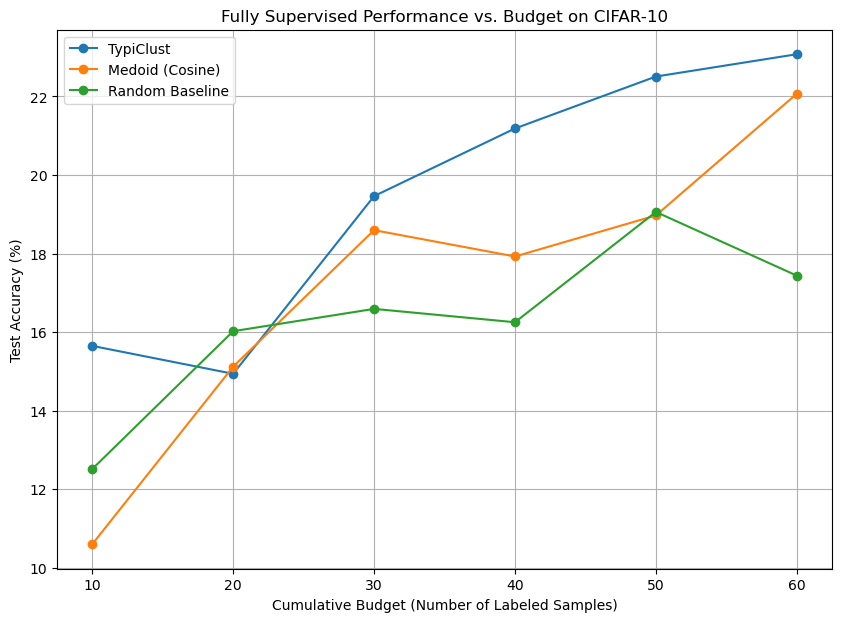

In [27]:
# --- Plot the results ---
plt.figure(figsize=(10, 7))

for method, accuracies in all_results.items():
    plt.plot(budgets, accuracies, marker='o', linestyle='-', label=method)

plt.title('Fully Supervised Performance vs. Budget on CIFAR-10')
plt.xlabel('Cumulative Budget (Number of Labeled Samples)')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.legend()
plt.xticks(budgets)
plt.show()

In [28]:
#calculate the mean and std for each method

# k=10 results

typiclust_k10 = [17.53,16.55,16.49,15.16,17.21,16.57,14.95,17.34,16.98,15.84]
medoid_k10 = [13.33, 11.86, 13.10, 13.45, 12.29, 10.18, 13.30, 13.27, 13.17, 13.97]
random_k10 = [12.58, 14.36, 12.73, 12.76, 10.51, 12.15, 11.86, 14.26, 12.52, 11.27]

# k=20 results
typiclust_k20 = [16.01, 17.51, 18.59, 18.04, 17.56, 13.75, 17.43, 15.84, 16.80, 19.12]
medoid_k20 = [16.28, 16.01, 14.87, 16.21, 17.44, 15.87, 15.73, 16.32, 15.76, 14.82]
random_k20 = [12.19, 12.59, 14.00, 13.90, 11.72, 13.24, 11.73, 10.58, 11.93, 13.22]

# k=30 results
typiclust_k30 = [20.57, 18.25, 18.80, 19.63, 19.55, 18.71, 18.36, 18.45, 19.48, 19.50]
medoid_k30 = [17.23, 17.04, 16.01, 19.84, 17.61, 18.89, 19.04, 17.73, 18.49, 18.77]
random_k30 = [16.81, 16.73, 16.54, 16.40, 17.71, 16.76, 17.37, 19.13, 17.21, 17.87]

# k=40 results
typiclust_k40 = [21.64, 23.15, 20.60, 21.87, 24.30, 20.56, 22.23, 20.42, 19.70, 20.12]
medoid_k40 = [18.05, 18.15, 18.19, 18.05, 17.92, 18.33, 17.54, 18.41, 19.18, 16.97]
random_k40 = [15.11, 16.28, 16.31, 16.63, 17.21, 15.30, 16.83, 17.50, 17.56, 16.33]

# k=50 results
typiclust_k50 = [21.38, 22.66, 20.47, 22.57, 21.51, 24.47, 24.05, 22.50, 22.96, 22.84]
medoid_k50 = [18.01, 20.64, 18.45, 16.97, 19.57, 18.57, 17.77, 20.01, 20.50, 20.45]
random_k50 = [20.51, 19.18, 21.55, 23.75, 21.03, 19.80, 19.42, 20.31, 20.62, 21.19]

# k=60 results
typiclust_k60 = [23.27, 25.01, 23.72, 23.08, 23.33, 22.50, 25.25, 23.32, 23.94, 24.28]
medoid_k60 = [18.55, 18.92, 18.68, 19.79, 20.47, 22.23, 18.99, 21.78, 19.74, 18.30]
random_k60 = [19.11, 19.11, 19.09, 18.51, 19.65, 20.27, 20.91, 17.42, 20.64, 20.20]

In [29]:
# Calculate means
typiclust_mean = [np.mean(typiclust_k10), np.mean(typiclust_k20), np.mean(typiclust_k30),
                  np.mean(typiclust_k40), np.mean(typiclust_k50), np.mean(typiclust_k60)]

medoid_mean = [np.mean(medoid_k10), np.mean(medoid_k20), np.mean(medoid_k30),
               np.mean(medoid_k40), np.mean(medoid_k50), np.mean(medoid_k60)]

random_mean = [np.mean(random_k10), np.mean(random_k20), np.mean(random_k30),
               np.mean(random_k40), np.mean(random_k50), np.mean(random_k60)]

# Calculate standard deviations
typiclust_std = [np.std(typiclust_k10), np.std(typiclust_k20), np.std(typiclust_k30),
                 np.std(typiclust_k40), np.std(typiclust_k50), np.std(typiclust_k60)]

medoid_std = [np.std(medoid_k10), np.std(medoid_k20), np.std(medoid_k30),
              np.std(medoid_k40), np.std(medoid_k50), np.std(medoid_k60)]

random_std = [np.std(random_k10), np.std(random_k20), np.std(random_k30),
              np.std(random_k40), np.std(random_k50), np.std(random_k60)]

print(f"Typiclust Mean (k=10 to k=60): {typiclust_mean}")
print(f"Medoid (Cosine) Mean (k=10 to k=60): {medoid_mean}")
print(f"Random Baseline Mean (k=10 to k=60): {random_mean}")
print(f"\nTypiclust Standard Deviation (k=10 to k=60): {typiclust_std}")
print(f"Medoid (Cosine) Standard Deviation (k=10 to k=60): {medoid_std}")
print(f"Random Baseline Standard Deviation (k=10 to k=60): {random_std}")

Typiclust Mean (k=10 to k=60): [16.461999999999996, 17.065000000000005, 19.13, 21.458999999999996, 22.541000000000004, 23.770000000000003]
Medoid (Cosine) Mean (k=10 to k=60): [12.792, 15.931000000000001, 18.065, 18.079, 19.094, 19.745]
Random Baseline Mean (k=10 to k=60): [12.5, 12.51, 17.253, 16.506, 20.736, 19.490999999999996]

Typiclust Standard Deviation (k=10 to k=60): [0.8442606232674841, 1.4747423503785329, 0.6981690339738652, 1.3870648867302495, 1.1392844245402463, 0.8218637356642529]
Medoid (Cosine) Standard Deviation (k=10 to k=60): [1.0381502781389602, 0.7118770961338766, 1.0839580250175738, 0.5430920732251578, 1.2409689762439675, 1.2940266612400226]
Random Baseline Standard Deviation (k=10 to k=60): [1.1264812470698304, 1.0291647098496917, 0.7795517943023416, 0.789850618788135, 1.2375152524312578, 1.0085182199643192]


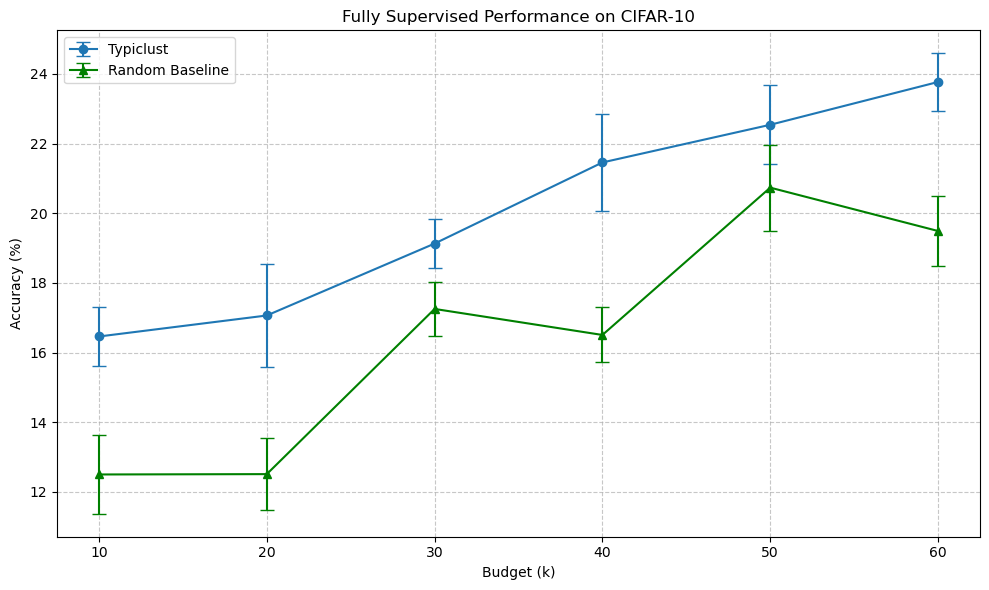

In [30]:
# Budget values for the x-axis
k_values = [10, 20, 30, 40, 50, 60]

plt.figure(figsize=(10, 6))

# Plot Typiclust with error bars
plt.errorbar(k_values, typiclust_mean, yerr=typiclust_std, fmt='-o', capsize=5, label='Typiclust')

# Plot Medoid (Cosine) with error bars
#plt.errorbar(k_values, medoid_mean, yerr=medoid_std, fmt='-s', capsize=5, label='Medoid (Cosine)')

# Plot Random Baseline with error bars
plt.errorbar(k_values, random_mean, yerr=random_std, fmt='-^', capsize=5, label='Random Baseline',color='green')

# Add labels and title
plt.xlabel('Budget (k)')
plt.ylabel('Accuracy (%)')
plt.title('Fully Supervised Performance on CIFAR-10')
plt.xticks(k_values) # Ensure x-axis ticks are at k values
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## __References__

@inproceedings{vangansbeke2020scan,
  <br>title={Scan: Learning to classify images without labels},
  <br>author={Van Gansbeke, Wouter and Vandenhende, Simon and Georgoulis, Stamatios and Proesmans, Marc and Van Gool, Luc},
  <br>booktitle={Proceedings of the European Conference on Computer Vision},
  <br>year={2020}
}
